In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [00:02<00:00, 10.2MB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 234kB/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:00<00:00, 4.43MB/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 16.5MB/s]


In [3]:
type(training_data)

torchvision.datasets.mnist.FashionMNIST

In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [7]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [31]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    print(f"size of the data = {size}")
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y_new)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    print(f"current type {type(current)}")
    return X

In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return X

In [32]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    re_train = train(train_dataloader, model, loss_fn, optimizer)
    re_test = test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
size of the data = 60000
loss: 1.165832  [   64/60000]
loss: 1.193469  [ 6464/60000]
loss: 1.021218  [12864/60000]
loss: 1.160231  [19264/60000]
loss: 1.039441  [25664/60000]
loss: 1.088512  [32064/60000]
loss: 1.130825  [38464/60000]
loss: 1.096773  [44864/60000]
loss: 1.141493  [51264/60000]
loss: 1.073863  [57664/60000]
current type <class 'int'>
Test Error: 
 Accuracy: 64.2%, Avg loss: 1.100244 

Epoch 2
-------------------------------
size of the data = 60000
loss: 1.165832  [   64/60000]
loss: 1.193469  [ 6464/60000]
loss: 1.021218  [12864/60000]
loss: 1.160231  [19264/60000]
loss: 1.039441  [25664/60000]
loss: 1.088512  [32064/60000]
loss: 1.130825  [38464/60000]
loss: 1.096773  [44864/60000]
loss: 1.141493  [51264/60000]
loss: 1.073863  [57664/60000]
current type <class 'int'>
Test Error: 
 Accuracy: 64.2%, Avg loss: 1.100244 

Epoch 3
-------------------------------
size of the data = 60000
loss: 1.165832  [   64/60000]
loss: 1.193469  [

In [12]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [13]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [14]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
X, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    X = X.to(device)
    pred = model(X)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


In [16]:
re_train.shape

torch.Size([32, 1, 28, 28])

In [17]:
28 * 28 * 32

25088

# Autoencoder

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Set random seed for reproducibility
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=128,
    shuffle=True
)

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=20):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        # Flatten input
        x = x.view(x.size(0), -1)

        # Get latent representation
        latent = self.encoder(x)

        # Reconstruct input
        reconstructed = self.decoder(latent)

        # Reshape to original dimensions
        reconstructed = reconstructed.view(x.size(0), 1, 28, 28)
        return reconstructed

In [4]:
# Initialize model and move to device
model = Autoencoder().to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (images, _) in enumerate(train_loader):
        # Move images to device
        images = images.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print epoch statistics
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

Epoch [1/20], Average Loss: 0.1390
Epoch [2/20], Average Loss: 0.0666
Epoch [3/20], Average Loss: 0.0527
Epoch [4/20], Average Loss: 0.0456
Epoch [5/20], Average Loss: 0.0417
Epoch [6/20], Average Loss: 0.0392
Epoch [7/20], Average Loss: 0.0373
Epoch [8/20], Average Loss: 0.0358
Epoch [9/20], Average Loss: 0.0346
Epoch [10/20], Average Loss: 0.0337
Epoch [11/20], Average Loss: 0.0329
Epoch [12/20], Average Loss: 0.0322
Epoch [13/20], Average Loss: 0.0317
Epoch [14/20], Average Loss: 0.0311
Epoch [15/20], Average Loss: 0.0306
Epoch [16/20], Average Loss: 0.0302
Epoch [17/20], Average Loss: 0.0299
Epoch [18/20], Average Loss: 0.0295
Epoch [19/20], Average Loss: 0.0292
Epoch [20/20], Average Loss: 0.0290


In [5]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])
tensor([6, 9, 9, 1, 3, 6, 1, 7, 5, 4])


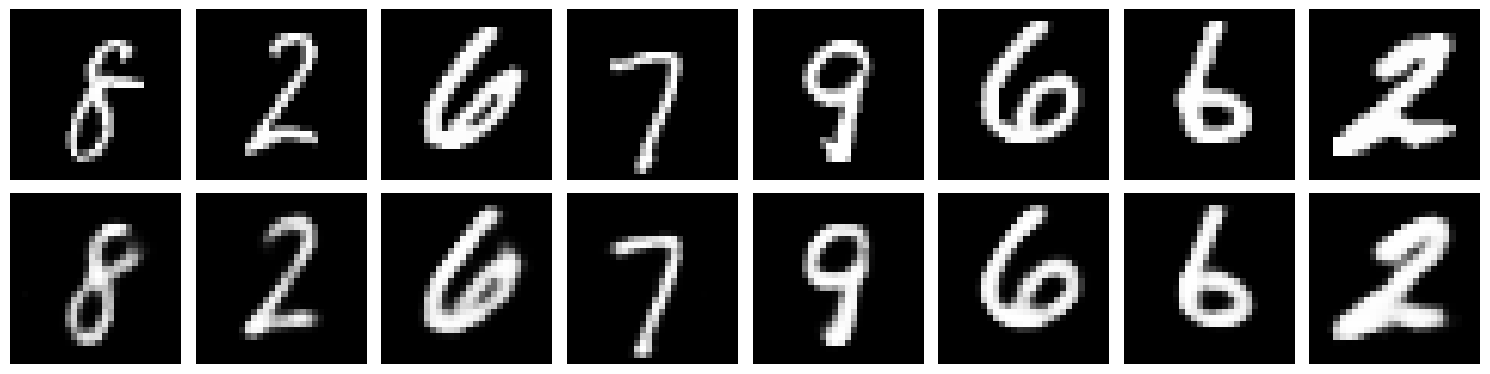

In [6]:
import matplotlib.pyplot as plt

def visualize_reconstruction(model, data_loader):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(data_loader))
        images = images.to(device)
        reconstructed = model(images)

        # Plot original vs reconstructed images
        fig, axes = plt.subplots(2, 8, figsize=(15, 4))
        for i in range(8):
            # Original images
            axes[0,i].imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
            axes[0,i].axis('off')

            # Reconstructed images
            axes[1,i].imshow(reconstructed[i].cpu().numpy().squeeze(), cmap='gray')
            axes[1,i].axis('off')

        plt.tight_layout()
        plt.show()
        return reconstructed

# Visualize results
reconstructed = visualize_reconstruction(model, train_loader)

In [7]:
reconstructed[0][0].shape

torch.Size([28, 28])

In [8]:
images[0][0].shape

torch.Size([28, 28])

In [9]:
(images[0][0] == reconstructed[0][0]).all()

tensor(False)

images size: torch.Size([128, 1, 28, 28])
<class 'numpy.ndarray'>
(128, 20)
torch.Size([128, 784])
128 1000 128


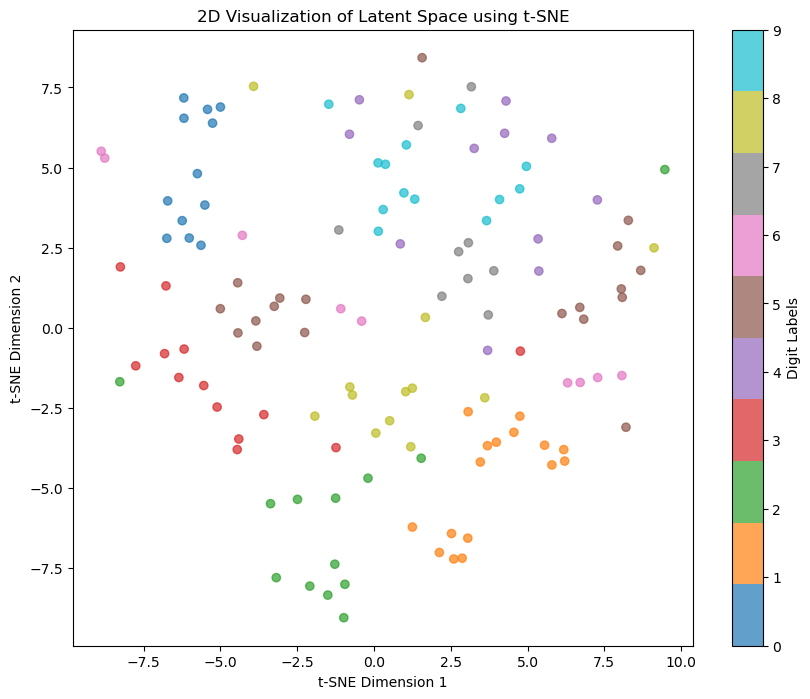

In [19]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_latent_space(model, data_loader, n_samples=1000):
    model.eval()
    with torch.no_grad():
        # Get a batch of data
        images, labels = next(iter(data_loader))
        images, labels = images[:n_samples], labels[:n_samples]  # Limit the number of samples
        images = images.to(device)
        print(f"images size: {images.shape}")

        # Pass images through encoder to get latent vectors
        latent_vectors = model.encoder(images.view(images.size(0), -1)).cpu().numpy()
        labels = labels.numpy()
        print(type(latent_vectors))
        print(latent_vectors.shape)
        print(images.view(images.size(0), -1).shape)
        print(len(labels), n_samples, images.size(0))


    # Apply t-SNE to reduce latent space to 2D, default perplexity = 30
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_vectors)

    # Plot the 2D latent space with labels
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(10), label='Digit Labels')
    plt.title('2D Visualization of Latent Space using t-SNE')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

# Visualize the latent space
visualize_latent_space(model, train_loader)


In [11]:
model.encoder?

Signature:      model.encoder(*args, **kwargs)
Type:           Sequential
String form:   
Sequential(
           (0): Linear(in_features=784, out_features=400, bias=True)
           (1): ReLU()
           (2): Line <...> atures=200, bias=True)
           (3): ReLU()
           (4): Linear(in_features=200, out_features=20, bias=True)
           )
Length:         5
File:           ~/miniforge3/envs/ecg/lib/python3.13/site-packages/torch/nn/modules/container.py
Docstring:     
A sequential container.

Modules will be added to it in the order they are passed in the
constructor. Alternatively, an ``OrderedDict`` of modules can be
passed in. The ``forward()`` method of ``Sequential`` accepts any
input and forwards it to the first module it contains. It then
"chains" outputs to inputs sequentially for each subsequent module,
finally returning the output of the last module.

The value a ``Sequential`` provides over manually calling a sequence
of modules is that it allows treating the whole con